In [45]:
import gmsh
import pygmsh
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [9]:
class GMSHParser:
    def __init__(self, file_path: str, dims: int = 2):
        self._file_path = file_path
        self._dims = dims

        self._elements = []
        self._common_parse()

    def _common_parse(self):
        with pygmsh.geo.Geometry() as geom:
            if self._check_file_type() in ['geo', 'msh']:
                self._parse_geo_file()
            elif self._check_file_type() == 'stl':
                self._parse_stl_file()
            else:
                raise TypeError('Unknown file type')

            geom.generate_mesh(dim=3, algorithm=8)

            self._get_elements()

    def _check_file_type(self):
        return self._file_path.split('.')[-1]

    def _parse_geo_file(self):
        gmsh.open(self._file_path)

    def _parse_stl_file(self):
        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 1)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 2)
        gmsh.option.setNumber("Mesh.Optimize", 1)
        gmsh.option.setNumber("Mesh.QualityType", 2)

        gmsh.merge(self._file_path)

        n = gmsh.model.getDimension()
        s = gmsh.model.getEntities(n)
        l = gmsh.model.geo.addSurfaceLoop([s[i][1] for i in range(len(s))])
        gmsh.model.geo.addVolume([l])

    def _get_elements(self):

        elems = gmsh.model.mesh.getElements()

        for i in range(len(elems[1])):
            if elems[2][i].shape[0] / elems[1][i].shape[0] == self._dims + 1:
                dim = i

        if dim is None:
            raise RuntimeError('Incorrect file structure')

        idxs = gmsh.model.mesh.getElements()[1][dim]
        for idx in idxs:
            elem = gmsh.model.mesh.getElement(idx)[1]
            nodes = []
            for node_idx in elem:
                node = gmsh.model.mesh.getNode(node_idx)[0]
                nodes.append(node)
            self._elements.append(np.array(nodes))

    def get_numpy(self):
        return np.array(self._elements)

In [63]:
def get_squares_from_verticles_3d(verticles_3d):
    results = np.zeros(verticles_3d.shape[0])
    for triangle in nb.prange(verticles_3d.shape[0]):
        verticles = verticles_3d[triangle]
        verticles_x = verticles[:, 0]
        verticles_y = verticles[:, 1]
        verticles_z = verticles[:, 2]
        
        det1 = np.linalg.det(np.vstack([np.ones((verticles_x.shape[0], )), verticles_x, verticles_y]))
        det2 = np.linalg.det(np.vstack([np.ones((verticles_x.shape[0], )), verticles_x, verticles_z]))
        det3 = np.linalg.det(np.vstack([np.ones((verticles_x.shape[0], )), verticles_y, verticles_z]))
        
        results[triangle] = (1/2) * np.sqrt(det1 ** 2 + det2 ** 2 + det3 **2)
    return results

In [41]:
parser = GMSHParser(file_path="../resources/mesh/Mesh2d_test.msh", dims=2)

In [74]:
verticles_3d = parser.get_numpy()
verticles_2d = verticles_3d[:, :, :2]             # Mesh берет 3 измерения, сокращаем до двух
collocations_2d = verticles_2d.mean(axis = 1)           # по вершинам считаем треугольники
squares = get_squares_from_verticles_3d(verticles_3d)

In [75]:
squares.shape

(9240,)

In [67]:
collocations_2d

array([[0.02519488, 0.95145922],
       [0.98104153, 0.32602327],
       [0.13720986, 0.69773787],
       ...,
       [0.45343145, 0.82716575],
       [0.3252505 , 0.37840028],
       [0.62323602, 0.53252616]])

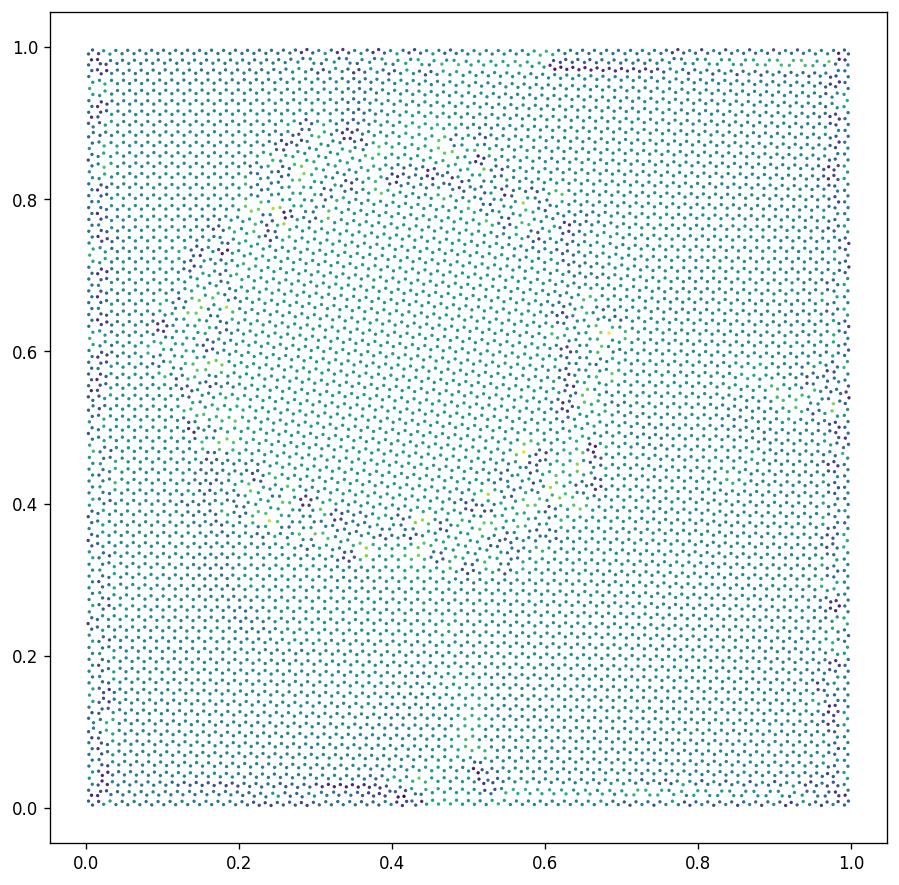

In [76]:
plt.figure(figsize = (9, 9), dpi = 120)
plt.scatter(collocations_2d[:, 0], collocations_2d[:, 1], c = squares, s = 1)